<a href="https://colab.research.google.com/github/iamsauravsharma/insincere-question-classification/blob/bishal/Lstm%2Bcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"bishalgaire360","key":"69b39489849cd899eaa93339bad30cdb"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c quora-insincere-questions-classification
from zipfile import ZipFile
file_name="train.csv.zip"
#file_name="embeddings.zip"
with ZipFile(file_name,'r') as zip:
    zip.extractall()
    print('Done')
file_name="embeddings.zip"
with ZipFile(file_name,'r') as zip:
    zip.extractall()
    print('Done')
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
df=pd.read_csv('train.csv')
from tqdm import tqdm_notebook
import numpy as np
emb_file = "glove.840B.300d/glove.840B.300d.txt"
#emb_file ="GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin"
glove_dic = {}
for line in tqdm_notebook(open(emb_file)):
    temp = line.split(" ")
    glove_dic[temp[0]] = np.asarray(temp[1:],dtype='float32')
def clean_text(x):

    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        x = x.replace(punct, '')
    return x
df["question_text"] = df["question_text"].progress_apply(lambda x: clean_text(x))
del df['qid']
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
n_words = 50000
tokenizer = Tokenizer(num_words=n_words)
tokenizer.fit_on_texts(list(train.question_text))

q_train = tokenizer.texts_to_sequences(train.question_text)
q_val = tokenizer.texts_to_sequences(val.question_text)
#q_test = tokenizer.texts_to_sequences(df_test.question_text)

max_len = 100
q_train = pad_sequences(q_train,maxlen=max_len)
q_val = pad_sequences(q_val,maxlen=max_len)
#q_test = pad_sequences(q_test,maxlen=max_len)

y_train = train.target
y_val = val.target

del train,val,df
word_index = tokenizer.word_index
emb_size = glove_dic['.'].shape[0]
emb_matrix = np.zeros((n_words,emb_size))
for w,index in word_index.items():
    if index >= n_words:
        continue
    vec = glove_dic.get(w)
    if vec is not None:
        emb_matrix[index,:] = vec
train, val = train_test_split(df, test_size=0.1, random_state=42)
n_words = 50000
tokenizer = Tokenizer(num_words=n_words)
tokenizer.fit_on_texts(list(train.question_text))

q_train = tokenizer.texts_to_sequences(train.question_text)
q_val = tokenizer.texts_to_sequences(val.question_text)
#q_test = tokenizer.texts_to_sequences(df_test.question_text)

max_len = 100
q_train = pad_sequences(q_train,maxlen=max_len)
q_val = pad_sequences(q_val,maxlen=max_len)
#q_test = pad_sequences(q_test,maxlen=max_len)

y_train = train.target
y_val = val.target

del train,val
word_index = tokenizer.word_index
emb_size = glove_dic['.'].shape[0]
emb_matrix = np.zeros((n_words,emb_size))
for w,index in word_index.items():
    if index >= n_words:
        continue
    vec = glove_dic.get(w)
    if vec is not None:
        emb_matrix[index,:] = vec


train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
embeddings.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Done
Done


  0%|          | 3251/1306122 [00:00<00:40, 32509.95it/s]

100%|██████████| 1306122/1306122 [00:15<00:00, 84486.89it/s]
Using TensorFlow backend.


NameError: ignored

In [0]:
from keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#find the best threshold
def optim_thres(y_val,y_pred):
    score = 0
    thresholds = np.arange(0.1,0.501,0.01)
    for thres in thresholds:
        thres = np.round(thres,2)
        temp_pred = (y_pred > thres).astype(int)
        temp_score = f1_score(y_val,temp_pred)
        print("Thres: {} --------- F1: {}".format(thres,temp_score))
        if temp_score > score:
            score = temp_score
            final_thres = thres
    return final_thres

In [0]:
import keras
from keras import initializers, regularizers, constraints
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)
        
    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True
        
    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)
    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim

In [43]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import LSTM,Bidirectional,TimeDistributed, Embedding,Dense,Input,GlobalMaxPool1D,Flatten,Dropout,Conv1D
from keras.layers import CuDNNLSTM,CuDNNGRU
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Embedding,Flatten,Dense
from keras.optimizers import Adam,Adamax
from keras.engine.topology import Layer

inp = Input(shape=(max_len,))
x = Embedding(input_dim=n_words,output_dim=emb_size, weights=[emb_matrix])(inp)
x = Bidirectional(CuDNNLSTM(100, return_sequences=True))(x)
#x = Attention(step_dim=max_len)(x)
#model.add(layers.Conv1D(128, 5, activation='relu'))
#model.add(layers.GlobalMaxPooling1D())
x=Conv1D(128,5,activation='relu')(x)
x = GlobalMaxPool1D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inp,output=x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 200)          321600    
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 96, 128)           128128    
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [35]:
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Embedding,Flatten,Dense
from keras.optimizers import Adam,Adamax
from keras.engine.topology import Layer



max_len = 100
#Attention(step_dim=max_len)(x)
model = Sequential()
model.add(layers.Embedding(input_dim=n_words, 
                           output_dim=emb_size, 
                           input_length=max_len,
                           weights=[emb_matrix]))
#model.add
#model.add(Attention(step_dim=max_len))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',f1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 300)          15000000  
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 96, 128)           192128    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 11        
Total params: 15,193,429
Trainable params: 15,193,429
Non-trainable params: 0
_________________________________________________________________


In [22]:
model_name = 'lstm_glove_emb'
checkpoint = ModelCheckpoint(filepath='./{}.hdf5'.format(model_name),
                             monitor='val_f1',mode='max',verbose=1,
                            save_best_only=True)

adamax= Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['acc',f1])
history  = model.fit(q_train,y_train,batch_size=1500,epochs=7,
                     validation_data=(q_val,y_val),verbose=1,callbacks=[checkpoint])


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1175509 samples, validate on 130613 samples
Epoch 1/7
1175509/1175509 [==============================] - 112s 95us/step - loss: 0.1157 - acc: 0.9535 - f1: 0.5155 - val_loss: 0.1017 - val_acc: 0.9594 - val_f1: 0.6277

Epoch 00001: val_f1 improved from -inf to 0.62771, saving model to ./lstm_glove_emb.hdf5
Epoch 2/7
1175509/1175509 [==============================] - 108s 92us/step - loss: 0.0982 - acc: 0.9607 - f1: 0.6484 - val_loss: 0.0992 - val_acc: 0.9599 - val_f1: 0.6362

Epoch 00002: val_f1 improved from 0.62771 to 0.63621, saving model to ./lstm_glove_emb.hdf5
Epoch 3/7
1175509/1175509 [==============================] - 109s 92us/step - loss: 0.0888 - acc: 0.9646 - f1: 0.6903 - val_loss: 0.0997 - val_acc: 0.9597 - val_f1: 0.6514

Epoch 00003: val_f1 improved from 0.63621 to 0.65136, saving model to ./lstm_glove_emb.hdf5
Epoch 4/7
1175509/1175509 [==============================] - 108s 92us/step -

NameError: ignored

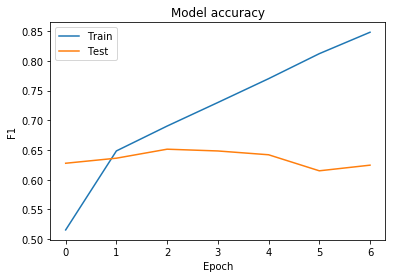

In [23]:
import matplotlib.pyplot as plt
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('Model accuracy')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
